In [1]:
import pandas as pd
import os

ep4 = pd.read_csv('SW_EpisodeIV.txt', delimiter='\t', header=None, names=['character/dialogue'])
ep5 = pd.read_csv('SW_EpisodeV.txt', delimiter='\t', header=None, names=['character/dialogue'])
ep6 = pd.read_csv('SW_EpisodeVI.txt', delimiter='\t', header=None, names=['character/dialogue'])
episodes = [ep4, ep5, ep6]

In [2]:
ep4

,character/dialogue
0,"character ""dialogue"""
1,"1 ""THREEPIO"" ""Did you hear that? They've shut..."
2,"2 ""THREEPIO"" ""We're doomed!"""
3,"3 ""THREEPIO"" ""There'll be no escape for the Pr..."
4,"4 ""THREEPIO"" ""What's that?"""
...,...
1006,"1006 ""LUKE"" ""Oh, no!"""
1007,"1007 ""THREEPIO"" ""Oh, my! Artoo! Can you hear..."
1008,"1008 ""TECHNICIAN"" ""We'll get to work on him ri..."
1009,"1009 ""THREEPIO"" ""You must repair him! Sir, if..."


In [3]:
def convertToProperDf(df):
    texts = df["character/dialogue"][1:]
    characters = []
    dialogues = []
    for text in texts:
        tup = [t.strip('"') for t in text.split('"') if t.strip()]
        new_tup = (tup[0], tup[1], " ".join(tup[2:]))
        number, character, dialogue = new_tup
        characters.append(character)
        dialogues.append(dialogue)
    new_df = pd.DataFrame({'character': characters, 'dialogue': dialogues})
    return new_df

cleaned_episodes = [convertToProperDf(episode) for episode in episodes]
cleaned_episodes[0]

,character,dialogue
0,THREEPIO,Did you hear that? They've shut down the main...
1,THREEPIO,We're doomed!
2,THREEPIO,There'll be no escape for the Princess this time.
3,THREEPIO,What's that?
4,THREEPIO,I should have known better than to trust the l...
...,...,...
1005,LUKE,"Oh, no!"
1006,THREEPIO,"Oh, my! Artoo! Can you hear me? Say somethi..."
1007,TECHNICIAN,We'll get to work on him right away.
1008,THREEPIO,"You must repair him! Sir, if any of my circui..."


In [4]:
cleaned_episodes[0].to_csv('SW_EpisodeIV.csv', sep=";", index=False)
cleaned_episodes[1].to_csv('SW_EpisodeV.csv', sep=";", index=False)
cleaned_episodes[2].to_csv('SW_EpisodeVI.csv', sep=";", index=False)

In [5]:
def findNodes(name, df):
    nunique = df.character.unique().tolist()
    print(f"Number of unique characters for {name}: ", len(nunique))
    return nunique

def findLinks(name, df):
    links = []
    dialogues = df.character.tolist()
    for i in range(2, len(dialogues)-1):
        characters = list(set(dialogues[i-2:i+1]))
        if len(characters) < 2:
            continue
        if [characters[0], characters[1]] not in links:
            links.append([characters[0], characters[1]])
        if len(characters) < 3:
            continue
        if [characters[0], characters[2]] not in links:
            links.append([characters[0], characters[2]])
    print(f"Number of links for {name}: ", len(links))
    return links

import operator

def top10Links(name, nodes, links):
    number_of_links = {key: 0 for key in nodes}
    for i in range(len(links)):
        # to avoid duplicates
        if [links[i][1], links[i][0]] not in links[:i]:
            number_of_links[links[i][0]] += 1
            number_of_links[links[i][1]] += 1
    inverse = [(value, key) for key, value in number_of_links.items()]
    top10 = sorted(inverse, key=operator.itemgetter(0), reverse=True)[:10]
    return top10

import matplotlib.pyplot as plt

def plotTopLinks(names, topLinks):
    for name, topLink in zip(names, topLinks):
        x = [t[1] for t in topLink]
        y = [t[0] for t in topLink]
        plt.bar(x,y)
        plt.title(f"Top 10 links for {name}")
        plt.xlabel("Character")
        plt.ylabel("Number of links")
        plt.xticks(fontsize=8, rotation=45)
        plt.show()

In [6]:
names = ["Episode IV", "Episode V", "Episode VI"]
nodes = [findNodes(name, ep) for name, ep in zip(names, cleaned_episodes)]
links = [findLinks(name, ep) for name, ep in zip(names, cleaned_episodes)]

Number of unique characters for Episode IV:  60
Number of unique characters for Episode V:  49
Number of unique characters for Episode VI:  53
Number of links for Episode IV:  212
Number of links for Episode V:  145
Number of links for Episode VI:  152


In [7]:
print("Total number of nodes: ", sum([len(node) for node in nodes]))
print("Total number of links: ", sum([len(link) for link in links]))
LinksTop10 = [top10Links(name, node, link) for name, node, link in zip(names, nodes, links)]

Total number of nodes:  162
Total number of links:  509


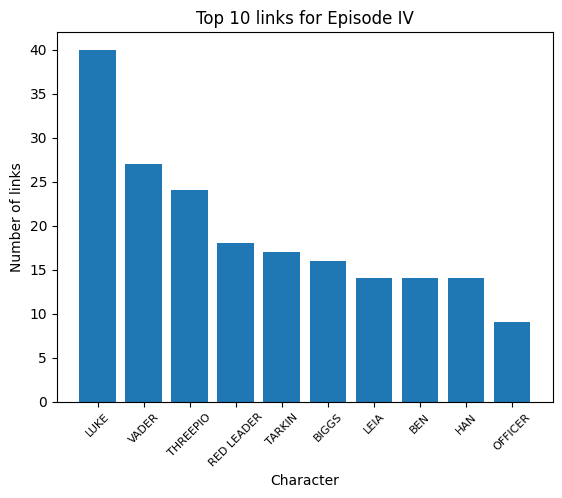

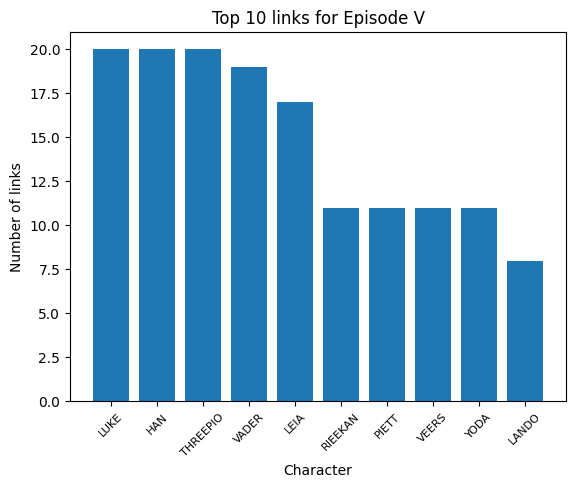

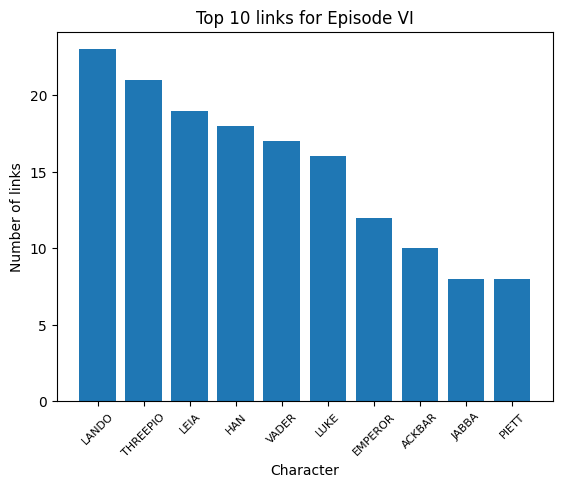

In [8]:
plotTopLinks(names, LinksTop10)

We will now try to make a temporal by looking a some of the most important characters and how their links to other characters develop over time:

In [51]:
def number_of_links_over_time(character, links):
    character_name = character.upper()
    all_nodes = []
    all_links = []
    nodes_for_each_ep = []
    links_for_each_ep = []
    for links_for_ep in links:
        for link in links_for_ep:
            if link[0] == character_name:
                nodes_for_each_ep.append(link[1])
            if link[1] == character_name:
                nodes_for_each_ep.append(link[0])
            if character_name in link:
                links_for_each_ep.append(tuple(link))
        all_nodes.append(nodes_for_each_ep[:])
        all_links.append(links_for_each_ep[:])
    print("Nodes: ", [len(node) for node in all_nodes])
    print("Links: ", [len(link) for link in all_links])
    return all_nodes, all_links

def number_of_links_lst(all_nodes, all_links):
    return [len(node) for node in all_nodes], [len(link) for link in all_links]

In [52]:
import networkx as nx
import netwulf

def make_graph(nodes, links):
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(links)
    return G

def draw_graphs(graphs):
    fig, axs = plt.subplots(1, len(graphs), figsize=(5*len(graphs), 5))
    for i, graph in enumerate(graphs):
        pos = nx.spring_layout(graph)
        nx.draw(graph, pos=pos, with_labels=True, font_size = 5, ax=axs[i])
        #plt.title(f"Episode {i+4}")
        #plt.show()
        axs[i].set_title(f'Episode {i+1}')

nodes_for_each_ep, links_for_each_ep = number_of_links_over_time("LUKE", links)
print(*[(len(node), len(link)) for node, link in zip(nodes_for_each_ep, links_for_each_ep)], sep="\n")

Nodes:  [45, 66, 82]
Links:  [45, 66, 82]
(45, 45)
(66, 66)
(82, 82)


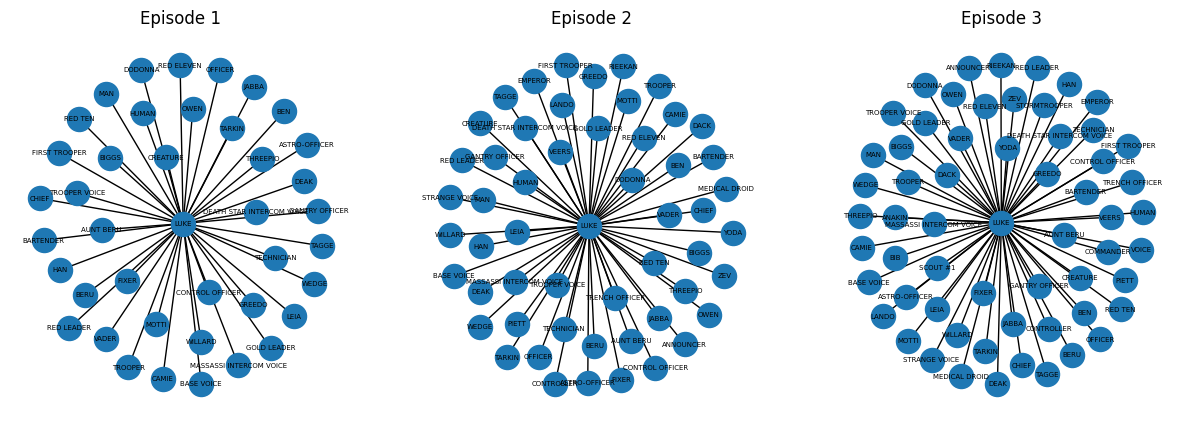

In [54]:
graphs = [make_graph(node, link) for node, link in zip(nodes_for_each_ep, links_for_each_ep)]
draw_graphs(graphs)
luke_len = number_of_links_lst(nodes_for_each_ep, links_for_each_ep)

We will now replicate for Threepio:

Nodes:  [32, 58, 84]
Links:  [32, 58, 84]


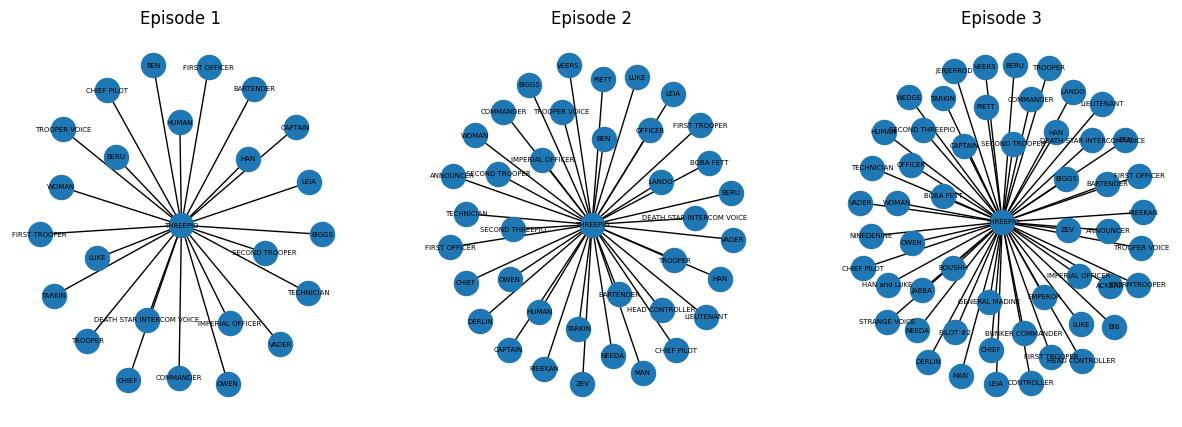

In [57]:
nodes_for_each_ep, links_for_each_ep = number_of_links_over_time("threepio", links)
graphs = [make_graph(node, link) for node, link in zip(nodes_for_each_ep, links_for_each_ep)]
draw_graphs(graphs)
threepio_len = number_of_links_lst(nodes_for_each_ep, links_for_each_ep)

Here it is obvious that both Luke and C-3PO (ThreePio) develop a 

In [65]:
def procent_rise(args):
    nodes, links = args
    nodes_percentage = [round((node - nodes[0])/nodes[0]*100, 4) for node in nodes]
    links_percentage = [round((link - links[0])/links[0]*100, 4) for link in links]
    print("Rise in nodes: ", nodes_percentage)
    print("Rise in links: ", links_percentage)
    return nodes_percentage, links_percentage

print("Luke: ")
procent_rise(luke_len)
print("\nThreepio: ")
procent_rise(threepio_len)

Luke: 
Rise in nodes:  [0.0, 46.6667, 82.2222]
Rise in links:  [0.0, 46.6667, 82.2222]

Threepio: 
Rise in nodes:  [0.0, 81.25, 162.5]
Rise in links:  [0.0, 81.25, 162.5]


([0.0, 81.25, 162.5], [0.0, 81.25, 162.5])

## Word Frequency

In [66]:
cleaned_episodes[0]

,character,dialogue
0,THREEPIO,Did you hear that? They've shut down the main...
1,THREEPIO,We're doomed!
2,THREEPIO,There'll be no escape for the Princess this time.
3,THREEPIO,What's that?
4,THREEPIO,I should have known better than to trust the l...
...,...,...
1005,LUKE,"Oh, no!"
1006,THREEPIO,"Oh, my! Artoo! Can you hear me? Say somethi..."
1007,TECHNICIAN,We'll get to work on him right away.
1008,THREEPIO,"You must repair him! Sir, if any of my circui..."


In [69]:
dialogues = [ep["dialogue"].values for ep in cleaned_episodes]
dialogues[0]

array(["Did you hear that?  They've shut down the main reactor.  We'll be destroyed for sure.  This is madness!",
       "We're doomed!",
       "There'll be no escape for the Princess this time.", ...,
       "We'll get to work on him right away.",
       "You must repair him!  Sir, if any of my circuits or gears will help, I'll gladly donate them.",
       "He'll be all right."], dtype=object)

In [82]:
!pip3 install nltk

In [85]:
import collections
import nltk
nltk.download("stopwords")
stopwords = set(nltk.corpus.stopwords.words("english"))



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lucasvilsen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [97]:
texts = [(" ".join(dialogue)).lower() for dialogue in dialogues]

6
5
3


/var/folders/pl/7f1cr2657p3bnpdt3bnm_9w00000gn/T/ipykernel_57101/3317700052.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(common_words, rotation=45)


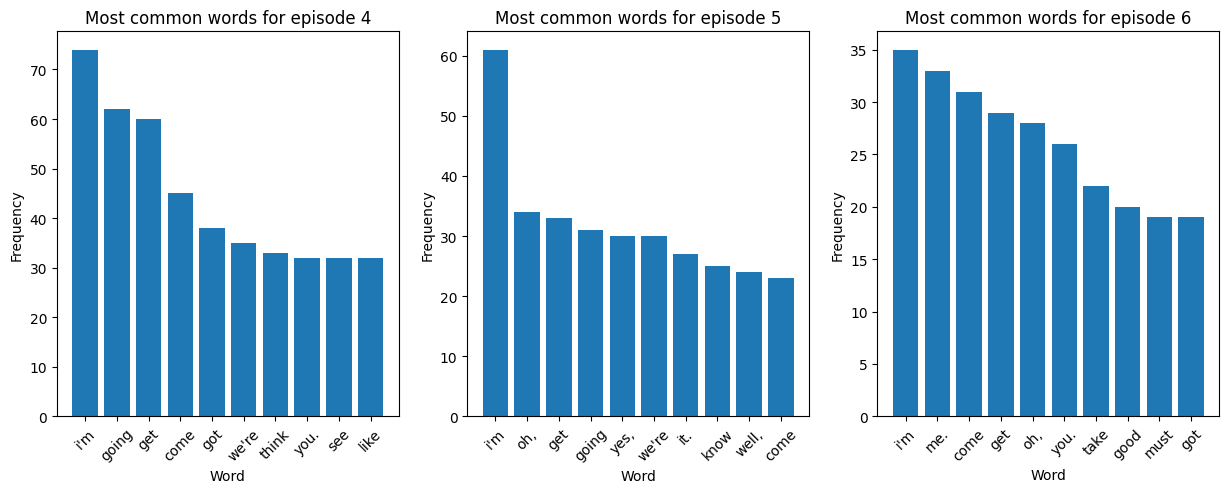

In [98]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

def count_words(text):
    word_counts = {}
    for word in text.split():
        if word not in stopwords:
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1
    return word_counts

for i, text in enumerate(texts):
    word_count = count_words(text)
    print(word_count["luke"])
    word_count = collections.Counter(word_count)
    common_words = [word for word, counter in word_count.most_common(10)]
    word_freq = [counter for word, counter in word_count.most_common(10)]

    axs[i].bar(common_words, word_freq)
    axs[i].set_title(f"Most common words for episode {i+4}")
    axs[i].set_xlabel("Word")
    axs[i].set_xticklabels(common_words, rotation=45)
    axs[i].set_ylabel("Frequency")

In [ ]:
import collections
import nltk
nltk.download("stopwords")
stopwords = set(nltk.corpus.stopwords.words("english"))



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lucasvilsen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
